In [1]:
import gdal
import geopandas as gpd
import pandas as pd
import fiona as fi
import matplotlib
from osgeo import ogr
import json
import geojson
import os
from rasterstats import zonal_stats
import rasterio
import numpy as np
import time

## Function to calculate area (km2) of intersection

In [2]:
def calcArea (selectSites_gdf, envData_gdf, areaField, **options):
    
    try:
        ## intersect envData_gdf and selectedSites_gdf
        intersect = gpd.overlay(selectSites_gdf, envData_gdf, how='intersection')
        intersect[areaField] = intersect['geometry'].area/ 10**6
        totArea = intersect[areaField].sum()

        ## if regionField argument provided, then sum by each region and add rows for regions that have no intersecting polygons
        if options.get("regionField"):
            regionField = options.get("regionField")
            sumByZone = intersect.groupby([regionField])[areaField].sum().reset_index()
            allZones = selectSites_gdf[regionField].unique()

            for zone in allZones:
                if zone not in sumByZone[regionField].tolist():
                    sumByZone = pd.concat([sumByZone, pd.DataFrame(data = {regionField : [zone], areaField: [0]})], axis=0)
            totArea = sumByZone
            
            ## Create table of area sums of all selected sites
            sumSelectedSitesByZone = selectSites_gdf.groupby([regionField])[areaField].sum().reset_index()

            ## change area column
            sumSelectedSitesByZone = sumSelectedSitesByZone.rename(columns = {"Area": "area_allSelSites_km2"})[[regionField,"area_allSelSites_km2"]]

            ## merge the two df
            totArea = totArea.merge(sumSelectedSitesByZone, how = "inner", left_on=regionField, right_on=regionField)

            ## calculate percentage
            totArea["percent_selSites"] = totArea["Area"]/totArea['area_allSelSites_km2']
    
    ## if there's no overlap, then just return zeros for each zone as a dataframe
    except:
        regionField = options.get("regionField")
        allZones = selectSites_gdf[regionField].unique()
        totArea = pd.DataFrame(columns = [regionField, areaField])
        for zone in allZones:
                totArea = pd.concat([totArea, pd.DataFrame(data = {regionField : [zone], areaField: [0]})], axis=0)
        
        ## Create table of area sums of all selected sites
        sumSelectedSitesByZone = selectSites_gdf.groupby([regionField])[areaField].sum().reset_index()

        ## change area column
        sumSelectedSitesByZone = sumSelectedSitesByZone.rename(columns = {"Area": "area_allSelSites_km2"})[[regionField,"area_allSelSites_km2"]]

        ## merge the two df
        totArea = totArea.merge(sumSelectedSitesByZone, how = "inner", left_on=regionField, right_on=regionField)

        ## calculate percentage
        totArea["percent_selSites"] = totArea["Area"]/totArea['area_allSelSites_km2']
                    
            
    ## if renameField argument provided, then change areaField to renameField value
    if options.get("envDataField") and options.get("envDataName"):
        envDataField = options.get("envDataField")
        envDataName = options.get("envDataName")
        totArea[envDataField] = envDataName

    if options.get("renameAreaField"):
        totArea.rename(columns = {areaField : options.get("renameAreaField")}, inplace = True)

    ## if renameRegionField argument provided, then change regionField to renameRegionField value   
    if options.get("renameRegionField"):
        totArea.rename(columns = {regionField : options.get("renameRegionField")}, inplace = True)
        
    ## if selectedSitesFieldName and selectedSitesFilename provided, the create this column 
    if options.get("selectedSitesField") and options.get("selectedSitesFilename"):
        totArea[options.get("selectedSitesField")] = options.get("selectedSitesFilename")
        
    return totArea


## Create loop for selected sites

In [3]:
## set up lists

## List scenarios
scenList = ["In-State x Capped Basecase",  "Full WECC x Capped Basecase", "Part WECC x Capped Basecase", \
                        "In-State x Capped highDER", "Full WECC x Capped highDER", "Part WECC x Capped highDER", \
                        "In-State x Capped lowBatt", "Full WECC x Capped lowBatt", "Part WECC x Capped lowBatt",\
                        "In-State BaseUsex Basecase", "Full WECC BaseUsex Basecase", "Part WECC BaseUsex Basecase", \
                         "In-State BaseUsex highDER", "Full WECC BaseUsex highDER", "Part WECC BaseUsex highDER", \
                         "In-State BaseUsex lowBatt",  "Full WECC BaseUsex lowBatt", "Part WECC BaseUsex lowBatt",\
                        "In-State xW2W No Cap Basecase",\
                        "Full WECC xW2W No Cap Basecase",\
                        "Part WECC xW2W No Cap Basecase",\
                         "In-State xW2W No Cap highDER", "Full WECC xW2W No Cap highDER", \
                         "In-State xW2W No Cap lowBatt", "Full WECC xW2W No Cap lowBatt"]

## technologies
techList = ["Geothermal"] #, "Wind", "Solar"

df_RESOLVEscenarios_total = pd.read_csv(os.path.join("C:\\Users\\Grace\\Documents\\TNC_beyond50\\PathTo100\\", "RESOLVEoutputs", "Results Summary Workbook_v11_20181214_total.csv"))

## column order of final csv
master_df_col_list = ["tech", "envCat", "scenario", "selSites", "region", "envData","area_envData_km2", "area_allSelSites_km2", "percent_selSites"]

## empty dataframe of results
master_df = pd.DataFrame(columns = master_df_col_list)

## selected sites folder
selectedSitesFolder = "C:\\Users\\Grace\\Documents\\TNC_beyond50\\PathTo100\\spatialDisaggregation\\selectedsites_cleaned_shp"
allSelecteSitesList = [file for file in os.listdir(selectedSitesFolder) if file.endswith(".shp")]

## Environmental data
envDataGDB = "C:\\Users\\Grace\\Documents\\TNC_beyond50\\PathTo100\\dataCollection\\envImpactAssessment\\EnvImpactUnionSubgroups.gdb"
envDataLayerList = [{"envDataLayerName": "criticalHabitat_Union_sg5", "envDataGDB": envDataGDB, "envDataLabel": "criticalHabitat_SG05"}]

resultsFileName = os.path.join("C:\\Users\\Grace\\Documents\\TNC_beyond50\\PathTo100\\envImpactAssessment\\", "areaImpacted_SG05_GEOonly_df.csv")
'''
[{"envDataLayerName": "criticalHabitat_Union_sg5", "envDataGDB": envDataGDB, "envDataLabel": "criticalHabitat_SG05"},\
                   {"envDataLayerName": "WIND_SageGrouse_Union_sg6", "envDataGDB": envDataGDB, "envDataLabel": "sageGrouse_SG06"},\
                   {"envDataLayerName": "esri_justprime_250m_0267_sg7", "envDataGDB": envDataGDB, "envDataLabel": "primeFarmland_SG07"},\
                   {"envDataLayerName": "IBAs_April2018_Recognized_0110_sg8", "envDataGDB": envDataGDB, "envDataLabel": "IBAs_SG08"},\
                   {"envDataLayerName": "allWetlands_unioned_sg9", "envDataGDB": envDataGDB, "envDataLabel": "wetlands_SG09"},\
                   {"envDataLayerName": "BigGame_Union_sg10", "envDataGDB": envDataGDB, "envDataLabel": "bigGame_SG10"},\
                   {"envDataLayerName": "Intactness_Union_dissolved_sg11", "envDataGDB": envDataGDB, "envDataLabel": "intactness_SG11"}]
                   '''

'\n[{"envDataLayerName": "criticalHabitat_Union_sg5", "envDataGDB": envDataGDB, "envDataLabel": "criticalHabitat_SG05"},                   {"envDataLayerName": "WIND_SageGrouse_Union_sg6", "envDataGDB": envDataGDB, "envDataLabel": "sageGrouse_SG06"},                   {"envDataLayerName": "esri_justprime_250m_0267_sg7", "envDataGDB": envDataGDB, "envDataLabel": "primeFarmland_SG07"},                   {"envDataLayerName": "IBAs_April2018_Recognized_0110_sg8", "envDataGDB": envDataGDB, "envDataLabel": "IBAs_SG08"},                   {"envDataLayerName": "allWetlands_unioned_sg9", "envDataGDB": envDataGDB, "envDataLabel": "wetlands_SG09"},                   {"envDataLayerName": "BigGame_Union_sg10", "envDataGDB": envDataGDB, "envDataLabel": "bigGame_SG10"},                   {"envDataLayerName": "Intactness_Union_dissolved_sg11", "envDataGDB": envDataGDB, "envDataLabel": "intactness_SG11"}]\n                   '

In [ ]:
## test read all envDataLayers
for envData in envDataLayerList:
    
    ## read envData as geodataframe
    envData_gdf = gpd.read_file(envData["envDataGDB"], driver='FileGDB', layer = envData["envDataLayerName"])
    print("Succeeded in reading " + envData["envDataLayerName"])

In [5]:
envData_gdf = gpd.read_file("C:\\Users\\Grace\\Documents\\TNC_beyond50\\PathTo100\\dataCollection\\envImpactAssessment\\Intactness_Union_dissolved_sg11.shp")

In [13]:
## test run
techList = ["Wind"]
envDataLayerList = [{"envDataLayerName": "allWetlands_unioned_sg9", "envDataGDB": envDataGDB, "envDataLabel": "wetlands_SG09"}]
scenList = ["Full WECC x Capped Basecase", "In-State x Capped Basecase"]
resultsFileName = os.path.join("C:\\Users\\Grace\\Documents\\TNC_beyond50\\PathTo100\\envImpactAssessment\\", "areaImpacted_sg6_df.csv")

In [4]:
## Loop through lists
start_time = time.time()
print(start_time)

for envData in envDataLayerList:
    print("")
    print("========>> Env Data: " +  envData["envDataLayerName"])
    ## read envData as geodataframe
    envData_gdf = gpd.read_file(envData["envDataGDB"], driver='FileGDB', layer = envData["envDataLayerName"])
    print(str((time.time() - start_time)/(60)) + " minutes")
    
    for tech in techList:
        ## categories
        if tech == "Geothermal":
            catList = {"Cat1" : "geothermal_cat1b", "Cat2" : "geothermal_cat2f"}#,\
                    #"Cat3" : "geothermal_cat3"}#, "Cat4": "geothermal_cat4"}

        if tech == "Wind":
            catList = {"Cat1" : "wind_0_03_nonEnv_r3_cat1b_singlepart_gt1km2","Cat2" : "wind_0_03_nonEnv_r3_cat2f_singlepart_gt1km2",\
                    "Cat3" : "wind_0_03_nonEnv_r3_cat3c_singlepart_gt1km2"}#, "Cat4": "wind_0_03_nonEnv_r3_cat4_singlepart_gt1km2"}

        if tech == "Solar":
            catList = {"Cat1" : "solarPV_0_0_nonEnv_r1_cat1b_singlepart_gt1km2","Cat2" : "solarPV_0_0_nonEnv_r1_cat2f_singlepart_gt1km2",\
                    "Cat3" : "solarPV_0_0_nonEnv_r1_cat3c_singlepart_gt1km2"}#, "Cat4": "solarPV_0_0_nonEnv_r1_cat4_singlepart_gt1km2"}
        print(tech)
        
        for cat in catList:
            for scen in scenList:
                scen = scen.replace("x", cat)
                if scen in df_RESOLVEscenarios_total.columns: 
                    scenName_field = scen.replace(" ", "_").replace("-", "")                
                    print("")
                    geographyList = []
                    separator = "_" 
                    oos_RESOLVE_filename = separator.join([catList[cat], "PA", "OOS_RESOLVEZONE", "net", scenName_field, "selected.shp"])
                    oos_STATE_filename = separator.join([catList[cat], "PA", "state", "net", scenName_field, "selected.shp"])
                    instate_filename = separator.join([catList[cat], "PA", "CA_RESOLVEZONE", "net", scenName_field, "selected.shp"])

                    if "W2W" in scenName_field and "InState" not in scenName_field:
                        ## append both state and in-state filenames to geoList
                        geographyList.append({"file": oos_STATE_filename, "regionField": "STATE"})
                        geographyList.append({"file": instate_filename, "regionField": "RESOLVE_ZO"})
                        print("W2W scenario for " + oos_STATE_filename + " and " + instate_filename)

                    if "InState" in scenName_field:
                        ## append only state filename to geoList
                        geographyList.append({"file": instate_filename, "regionField": "RESOLVE_ZO"})
                        print("InState scenario for " + instate_filename)

                    if any(txt in scenName_field for txt in ["Capped","BaseUseCat1"]) and "InState" not in scenName_field:
                        ## append both OOS RESOLVE ZONES and in-state filenames to geoList
                        geographyList.append({"file": oos_RESOLVE_filename, "regionField": "RESOLVE_ZO"})
                        geographyList.append({"file": instate_filename, "regionField": "RESOLVE_ZO"})
                        print("OOS RESOLVE scenario for " + oos_RESOLVE_filename + " and " + instate_filename)

                    ## loop through each element of geoList
                    for geography in geographyList:
                        ## if file is in the geodatabase and it has not already been analyzed
                        ## ex: "geothermal_cat1b_PA_CA_RESOLVEZONE_net_Part_WECC_Cat1_Capped_highDER_selectedcriticalHabitat_SG05" not in list of these in the master_df
                        if geography['file'] in allSelecteSitesList: #and geography['file']+envData["envDataLabel"] not in (master_df["selSites"]+master_df['envData']).tolist():
                            
                            ## read selected sites (shp) as geodataframe
                            sp = gpd.read_file(os.path.join(selectedSitesFolder,geography['file']))

                            if len(sp) > 0:

                                ## apply CalcArea function by zone
                                area_df = calcArea(sp, envData_gdf, areaField = "Area", regionField = geography['regionField'], \
                                                   envDataField = "envData", envDataName = envData["envDataLabel"], \
                                                   renameAreaField = "area_envData_km2", renameRegionField = "region", \
                                                   selectedSitesField = "selSites", selectedSitesFilename = geography['file'])

                                ## add technology
                                area_df["tech"] = tech

                                ## add scenario name
                                area_df["scenario"] = scenName_field

                                ## add env cat
                                area_df["envCat"] = cat

                                ## reorder fields:
                                area_df = area_df[master_df_col_list]

                                ## append area_df to master df
                                master_df = pd.concat([master_df, area_df], axis = 0)

                                print("Completed " + geography["file"])
                                print(str((time.time() - start_time)/(60)) + " minutes")

                            else:
                                ## Create single row dataframe with NA for region and area_km2 to indicate that there are no selected sites for that scenario/geography
                                area_df = pd.DataFrame(data = {"tech": [tech], "envCat": [cat], "scenario": [scenName_field], \
                                                               "selSites": [geography['file']], "region": ["NA"], "envData": [envData["envDataLabel"]], \
                                                               "area_envData_km2": ["NA"], "area_allSelSites_km2" : ["NA"], "percent_selSites": ["NA"]})

                                ## append area_df to master df
                                master_df = pd.concat([master_df, area_df], axis = 0)

                                print("***There are no selected sites for empty " + geography["file"])
                        else:
                            print("Not in gdb or already analyzed and in master_df: " + geography['file'])
                            
                    print(str((time.time() - start_time)/(60)) + " minutes")
                    
        master_df.to_csv(path_or_buf = resultsFileName, index = False)
                            
elapsed_time = (time.time() - start_time)/(60)
print("^^^^ Total time for completion: " + str(elapsed_time) + " minutes")

1549840586.730325

========>> Env Data: criticalHabitat_Union_sg5
0.5656529068946838 minutes
Geothermal

InState scenario for geothermal_cat1b_PA_CA_RESOLVEZONE_net_InState_Cat1_Capped_Basecase_selected.shp
Completed geothermal_cat1b_PA_CA_RESOLVEZONE_net_InState_Cat1_Capped_Basecase_selected.shp
1.4318398118019104 minutes
1.4318398118019104 minutes

OOS RESOLVE scenario for geothermal_cat1b_PA_OOS_RESOLVEZONE_net_Full_WECC_Cat1_Capped_Basecase_selected.shp and geothermal_cat1b_PA_CA_RESOLVEZONE_net_Full_WECC_Cat1_Capped_Basecase_selected.shp
Completed geothermal_cat1b_PA_OOS_RESOLVEZONE_net_Full_WECC_Cat1_Capped_Basecase_selected.shp
2.931021213531494 minutes
Completed geothermal_cat1b_PA_CA_RESOLVEZONE_net_Full_WECC_Cat1_Capped_Basecase_selected.shp
4.155360225836436 minutes
4.155360225836436 minutes

OOS RESOLVE scenario for geothermal_cat1b_PA_OOS_RESOLVEZONE_net_Part_WECC_Cat1_Capped_Basecase_selected.shp and geothermal_cat1b_PA_CA_RESOLVEZONE_net_Part_WECC_Cat1_Capped_Basecase_se

## Read gdb files
### Issues having to do with reading gdb files:
Due to unique geometries specific to ArcGIS, we must first convert the gdb feature class into a shapefile and then back into a gdb feature class in order to read it using gpd. I could not do this using open source packages, so I wrote a python script using arcpy to convert all gdb feature classes to shapfiles and then back to gdb feature classes with the right field name length
These corrected gdb feature classes are in a new gdb called 'selectedSites_cleaned.gdb"

In [5]:
sp_gdb = r'C:\Users\Grace\Documents\TNC_beyond50\PathTo100\spatialDisaggregation\selectedSites_cleaned.gdb'
#sp_gdb_names = fi.listlayers(sp_gdb)
#print("\n".join(sp_gdb_names))

In [6]:
#sp = gpd.read_file(sp_gdb, driver='FileGDB', layer='solarPV_0_0_nonEnv_r1_cat3c_singlepart_gt1km2_PA_state_net_Full_WECC_Cat3W2W_No_Cap_Basecase_selected')
sp2 = gpd.read_file(sp_gdb, driver='FileGDB', layer='wind_0_03_nonEnv_r3_cat1b_singlepart_gt1km2_PA_OOS_RESOLVEZONE_net_Full_WECC_Cat1_Capped_Basecase_selected')
#sp = gpd.read_file(sp_gdb, driver='FileGDB', layer='solarPV_0_0_nonEnv_r1_cat1b_singlepart_gt1km2_PA_CA_RESOLVEZONE_net_Full_WECC_BaseUseCat1_Basecase_selected')

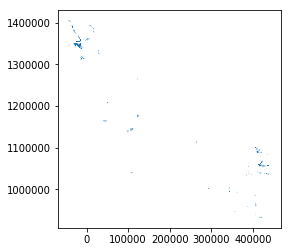

In [13]:
sp.plot()

## Read env data

In [3]:
## gdb paths
envCatGDB = r"C:\Users\Grace\Documents\TNC_beyond50\PathTo100\dataCollection\envData\envCat_merged.gdb"
envImpactDataGDB = r"C:\Users\Grace\Documents\TNC_beyond50\PathTo100\dataCollection\envImpactAssessment\envImpactData.gdb"
adminBound = r'C:\Users\Grace\Documents\TNC_beyond50\PathTo100\dataCollection\siteSuitabilityInputs_nonEnv.gdb'

weccBounds = gpd.read_file(adminBound,driver='FileGDB', layer='stateBound_baja')
#cat2_solar = gpd.read_file(envCatGDB, driver='FileGDB', layer='Cat2_solar')

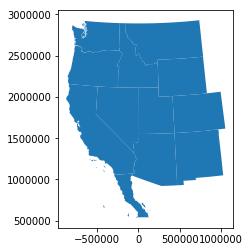

In [18]:
weccBounds.plot()

In [7]:
#critHabitat = gpd.read_file(envImpactDataGDB, driver='FileGDB', layer='CRITHAB_POLY_0051_s_proj')
critHabitat = gpd.read_file(envImpactDataGDB, driver='FileGDB', layer='WWWMP_ghma_mlsr_0260_proj')

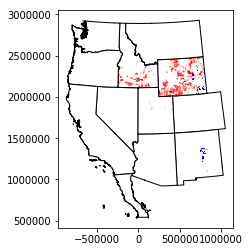

In [43]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.set_aspect('equal')
weccBounds.plot(ax=ax, color='white', edgecolor='black')
critHabitat.plot(ax=ax, color='red')
sp2.plot(ax=ax, color='blue')
plt.show()

In [50]:
intersect = gpd.overlay(sp2, critHabitat, how='intersection')

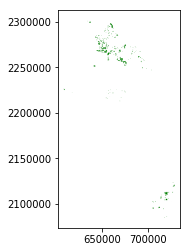

In [46]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
#critHabitat.plot(ax=ax, color='red')
#sp2.plot(ax=ax, color='blue')
intersect.plot(ax=ax, color='green')
plt.show()

In [47]:
intersect.head(2)

,Id,gridcode,Area,ORIG_FID,Text,RESOLVE_ZONE,NEAR_FID_netPPA,NEAR_DIST_netPPA,NEAR_FC_netPPA,netREN,...,goldenEagl,dt_conn,falcon,ghma_mlsr,STgrouse,BCbyways,Shape_Leng_2,Shape_Length_2,Shape_Area_2,geometry
0,7338,1,7.1875,1717,,Wyoming_Wind,195,39789.99037,C:\Users\Grace\Documents\TNC_beyond50\PathTo10...,0,...,Y,N,N,Y,N,N,3209.851962,3209.851962,483120.357522,POLYGON Z ((654789.1614999995 2280670.45949909...
1,7338,1,7.1875,1717,,Wyoming_Wind,195,39789.99037,C:\Users\Grace\Documents\TNC_beyond50\PathTo10...,0,...,Y,N,N,Y,N,N,316.056616,316.056616,4527.841866,POLYGON Z ((657039.1614999995 2281710.77494220...


In [52]:
intersect["Area"] = intersect['geometry'].area/ 10**6
intersect.head(2)

,Id,gridcode,Area,ORIG_FID,Text,RESOLVE_ZONE,NEAR_FID_netPPA,NEAR_DIST_netPPA,NEAR_FC_netPPA,netREN,...,goldenEagl,dt_conn,falcon,ghma_mlsr,STgrouse,BCbyways,Shape_Leng_2,Shape_Length_2,Shape_Area_2,geometry
0,7338,1,0.313083,1717,,Wyoming_Wind,195,39789.99037,C:\Users\Grace\Documents\TNC_beyond50\PathTo10...,0,...,Y,N,N,Y,N,N,3209.851962,3209.851962,483120.357522,POLYGON Z ((654789.1614999995 2280670.45949909...
1,7338,1,0.001603,1717,,Wyoming_Wind,195,39789.99037,C:\Users\Grace\Documents\TNC_beyond50\PathTo10...,0,...,Y,N,N,Y,N,N,316.056616,316.056616,4527.841866,POLYGON Z ((657039.1614999995 2281710.77494220...


In [53]:
## sum area column
intersect["Area"].sum()

142.05385531954198

In [186]:
sumByZone = intersect.groupby(['RESOLVE_ZONE'])['Area'].sum().reset_index()
sumByZone

,RESOLVE_ZONE,Area
0,Wyoming_Wind,142.053855


In [187]:
otherZones = sp2.RESOLVE_ZONE.unique()

for zone in otherZones:
    if zone not in sumByZone.RESOLVE_ZONE.tolist():
        print(zone)
        sumByZone = pd.concat([sumByZone, pd.DataFrame(data = {"RESOLVE_ZONE" : [zone], "Area": [0]})], axis=0)

Pacific_Northwest_Wind
New_Mexico_Wind


In [188]:
sumByZone

,RESOLVE_ZONE,Area
0,Wyoming_Wind,142.053855
0,Pacific_Northwest_Wind,0.000000
0,New_Mexico_Wind,0.000000


In [174]:
sumByZone

['Wyoming_Wind']

In [10]:
test = calcArea(sp2, critHabitat, areaField = "Area", regionField = "RESOLVE_ZONE", envDataField = "envData", envDataName = "criticalHabitat", renameAreaField = "area_km2", renameRegionField = "region", selectedSitesField = "selSites", selectedSitesFilename = "wind_0_03_nonEnv_r3_cat1b_singlepart_gt1km2_PA_OOS_RESOLVEZONE_net_Full_WECC_Cat1_Capped_Basecase_selected")
test

,region,area_km2,area_allSelSites_km2,percent_selSites,envData,selSites
0,Wyoming_Wind,142.053855,4507.773311,0.031513,criticalHabitat,wind_0_03_nonEnv_r3_cat1b_singlepart_gt1km2_PA...
1,Pacific_Northwest_Wind,0.000000,213.089739,0.000000,criticalHabitat,wind_0_03_nonEnv_r3_cat1b_singlepart_gt1km2_PA...
2,New_Mexico_Wind,0.000000,3620.565965,0.000000,criticalHabitat,wind_0_03_nonEnv_r3_cat1b_singlepart_gt1km2_PA...


In [191]:
test2 = calcArea(sp2, critHabitat)
test2

142.05385531954198

In [62]:
from rasterstats import zonal_stats
from rasterio.plot import show

In [65]:
hd_file = r'C:\Users\Grace\Documents\TNC_beyond50\PathTo100\dataCollection\envImpactAssessment\housingDensity\housingDen2010_merged_raster_proj.tif'
hd = rasterio.open(hd_file)

In [ ]:
ax = show((hd, 1))

In [ ]:
hd.profile
out_profile = hd.profile.copy()
out_affine = out_profile.pop("affine")
out_profile["transform"] = out_affine

In [77]:
## dissolve
sp2_diss = sp2.dissolve(by='gridcode')
sp2.head(2)
sp2_diss.head(2)

,geometry,Id,Area,ORIG_FID,Text,RESOLVE_ZONE,NEAR_FID_netPPA,NEAR_DIST_netPPA,NEAR_FC_netPPA,netREN,...,MWh,txArea,txAreaAdj,totArea,avgMWhperKm2,zoneID,Full_WECC_Cat1_Capped_Basecase,Shape_Leng,Shape_Length,Shape_Area
gridcode,,,,,,,,,,,,,,,,,,,,,
1,"(POLYGON Z ((811789.1614999995 1311677.7563 0,...",4849,4.871315,1104,,Pacific_Northwest_Wind,56,0.0,C:\Users\Grace\Documents\TNC_beyond50\PathTo10...,1,...,94320.034979,0.0,0.0,4.871315,19362.334545,OOS_RESOLVEZONE_28,True,12931.098666,12931.098525,4.871315e+06


In [79]:
#First we need to get the values of the dem as numpy array and the affine of the raster
#array = hd.read(1)
#affine = hd.affine()

# Now we can calculate the zonal statistics by using the function zonal_stats.
#zs_sp2 = zonal_stats(sp2, array, affine=affine, stats=['min', 'max', 'mean', 'median', 'majority'])

stats = zonal_stats(sp2_diss,r'C:\Users\Grace\Documents\TNC_beyond50\PathTo100\dataCollection\envImpactAssessment\housingDensity\housingDen2010_merged_raster_proj.tif',stats=['mean', 'min', 'max', 'median'])
print(stats)

[{'min': 0.0, 'max': 347.119276156, 'mean': 0.1669283951309634, 'median': 0.0}]


### Function to calculate zonal stats

In [80]:
def calcZS(zones, dissField, rasterPath, statsList):
    ## dissolve
    zones_diss = zones.dissolve(by=dissField)
    ## calc zonal stats
    stats = zonal_stats(zones_diss, rasterPath, stats=statsList)
    return stats

In [81]:
out = calcZS(sp2, "gridcode", r'C:\Users\Grace\Documents\TNC_beyond50\PathTo100\dataCollection\envImpactAssessment\housingDensity\housingDen2010_merged_raster_proj.tif',['mean', 'min', 'max', 'median'])
print(out)

[{'min': 0.0, 'max': 347.119276156, 'mean': 0.1669283951309634, 'median': 0.0}]


### Mosaic gaplc raster files

In [82]:
from rasterio.merge import merge
import glob
import os

In [91]:
search_criteria = "*.tif"

gaplc_folder = "C:\\Users\\Grace\\Documents\\TNC_beyond50\\PathTo100\\dataCollection\\envImpactAssessment\\gapLC"
gaplc_ls = []

for folder in os.listdir(gaplc_folder):
    searchTerm = os.path.join(gaplc_folder, folder, search_criteria)
    rast = glob.glob(searchTerm)
    gaplc_ls.append(rast)
    
gaplc_ls

[['C:\\Users\\Grace\\Documents\\TNC_beyond50\\PathTo100\\dataCollection\\envImpactAssessment\\gapLC\\gaplf2011lc_v30_AZ\\gaplf2011lc_v30_az.tif'],
 ['C:\\Users\\Grace\\Documents\\TNC_beyond50\\PathTo100\\dataCollection\\envImpactAssessment\\gapLC\\gaplf2011lc_v30_CA\\gaplf2011lc_v30_ca.tif'],
 ['C:\\Users\\Grace\\Documents\\TNC_beyond50\\PathTo100\\dataCollection\\envImpactAssessment\\gapLC\\gaplf2011lc_v30_ID\\gaplf2011lc_v30_id.tif'],
 ['C:\\Users\\Grace\\Documents\\TNC_beyond50\\PathTo100\\dataCollection\\envImpactAssessment\\gapLC\\gaplf2011lc_v30_NM\\gaplf2011lc_v30_nm.tif'],
 ['C:\\Users\\Grace\\Documents\\TNC_beyond50\\PathTo100\\dataCollection\\envImpactAssessment\\gapLC\\gaplf2011lc_v30_NV\\gaplf2011lc_v30_nv.tif'],
 ['C:\\Users\\Grace\\Documents\\TNC_beyond50\\PathTo100\\dataCollection\\envImpactAssessment\\gapLC\\gaplf2011lc_v30_OR\\gaplf2011lc_v30_or.tif'],
 ['C:\\Users\\Grace\\Documents\\TNC_beyond50\\PathTo100\\dataCollection\\envImpactAssessment\\gapLC\\gaplf2011lc_v30_U

In [94]:
src_files_to_mosaic = []

for fp in gaplc_ls:
    src = rasterio.open(fp[0])
    src_files_to_mosaic.append(src)
    
src_files_to_mosaic

[<open DatasetReader name='C:\Users\Grace\Documents\TNC_beyond50\PathTo100\dataCollection\envImpactAssessment\gapLC\gaplf2011lc_v30_AZ\gaplf2011lc_v30_az.tif' mode='r'>,
 <open DatasetReader name='C:\Users\Grace\Documents\TNC_beyond50\PathTo100\dataCollection\envImpactAssessment\gapLC\gaplf2011lc_v30_CA\gaplf2011lc_v30_ca.tif' mode='r'>,
 <open DatasetReader name='C:\Users\Grace\Documents\TNC_beyond50\PathTo100\dataCollection\envImpactAssessment\gapLC\gaplf2011lc_v30_ID\gaplf2011lc_v30_id.tif' mode='r'>,
 <open DatasetReader name='C:\Users\Grace\Documents\TNC_beyond50\PathTo100\dataCollection\envImpactAssessment\gapLC\gaplf2011lc_v30_NM\gaplf2011lc_v30_nm.tif' mode='r'>,
 <open DatasetReader name='C:\Users\Grace\Documents\TNC_beyond50\PathTo100\dataCollection\envImpactAssessment\gapLC\gaplf2011lc_v30_NV\gaplf2011lc_v30_nv.tif' mode='r'>,
 <open DatasetReader name='C:\Users\Grace\Documents\TNC_beyond50\PathTo100\dataCollection\envImpactAssessment\gapLC\gaplf2011lc_v30_OR\gaplf2011lc_v30

In [95]:
mosaic, out_trans = merge(src_files_to_mosaic)

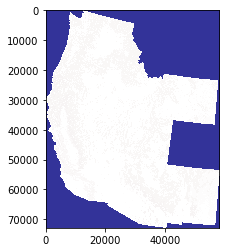

In [96]:
show(mosaic, cmap='terrain')

In [272]:
# Copy the metadata
out_meta = src.meta.copy()

# Update the metadata
'''
out_meta.update({"driver": "GTiff",
                 "height": mosaic.shape[1],
                 "width": mosaic.shape[2],
                 "transform": out_trans,
                "bigtiff":'YES'})
'''
## changed the nodata value to 999 because otherwise the tif file was going to exceed 4GB
out_meta.update(driver= "GTiff",
                 height = mosaic.shape[1],
                 width= mosaic.shape[2],
                compress='lzw',
                dtype = rasterio.int16,
                 transform= out_trans,
                nodata=999,
                bigtiff='YES')

# Write the mosaic raster to disk
out_fp = os.path.join(gaplc_folder, "gaplc_merged.tif")
with rasterio.open(out_fp, "w", **out_meta) as dest:
    dest.write(mosaic)

In [274]:
mosaic.crs

AttributeError: 'numpy.ndarray' object has no attribute 'crs'

In [ ]:
## save master_df to file
master_df.to_csv(path_or_buf = "C:\\Users\\Grace\\Documents\\TNC_beyond50\\PathTo100\\envImpactAssessment\\areaImpacted_df.csv", index = False)

In [353]:
master_df

,tech,envCat,scenario,region,envData,area_km2
0,Geothermal,Cat1,InState_Cat1_Capped_Basecase,Northern_California,criticalHabitat_SG05,0.000000
0,Geothermal,Cat1,Full_WECC_Cat1_Capped_Basecase,Pacific_Northwest_Geothermal,criticalHabitat_SG05,0.000004
0,Geothermal,Cat1,Full_WECC_Cat1_Capped_Basecase,Southern_Nevada_Geothermal,criticalHabitat_SG05,0.000000
0,Geothermal,Cat1,Full_WECC_Cat1_Capped_Basecase,Northern_California,criticalHabitat_SG05,0.000000
0,Geothermal,Cat1,Part_WECC_Cat1_Capped_Basecase,Pacific_Northwest_Geothermal,criticalHabitat_SG05,0.000004
0,Geothermal,Cat1,Part_WECC_Cat1_Capped_Basecase,Southern_Nevada_Geothermal,criticalHabitat_SG05,0.000000
0,Geothermal,Cat1,Part_WECC_Cat1_Capped_Basecase,Northern_California,criticalHabitat_SG05,0.000000
0,Geothermal,Cat1,InState_Cat1_Capped_highDER,Northern_California,criticalHabitat_SG05,0.000000
0,Geothermal,Cat1,Full_WECC_Cat1_Capped_highDER,Pacific_Northwest_Geothermal,criticalHabitat_SG05,0.000004
0,Geothermal,Cat1,Full_WECC_Cat1_Capped_highDER,Southern_Nevada_Geothermal,criticalHabitat_SG05,0.000000


In [320]:
## example of feature class that it empty (no selected sites)
sp = gpd.read_file(sp_gdb, driver='FileGDB', layer = "solarPV_0_0_nonEnv_r1_cat1b_singlepart_gt1km2_PA_OOS_RESOLVEZONE_net_Full_WECC_BaseUseCat1_Basecase_selected")
sp

,Id,gridcode,Area,ORIG_FID,Text,RESOLVE_ZONE,NEAR_FID_netPPA,NEAR_DIST_netPPA,netREN,NEAR_FID_Tx,...,txArea,txAreaAdj,totArea,avgMWhperKm2,zoneID,Full_WECC_BaseUseCat1_Basecase,Shape_Leng,Shape_Length,Shape_Area,geometry


In [153]:
oos_gdf = gpd.read_file(sp_gdb, driver='FileGDB', layer=oos_filename)
instate_gdf = gpd.read_file(sp_gdb, driver='FileGDB', layer=instate_filename)

oos_gdf.columns

Index(['Id', 'gridcode', 'Area', 'ORIG_FID', 'STFIPS', 'STATE', 'STPOSTAL',
       'DotRegion', 'GEMSID', 'NAME_0', 'NAME_1', 'Text', 'STFIPS_1',
       'STPOSTAL_1', 'DotRegion_1', 'GEMSID_1', 'NAME_01', 'NAME_12',
       'NEAR_FID_netPPA', 'NEAR_DIST_netPPA', 'netREN', 'NEAR_FID_Tx',
       'NEAR_DIST_Tx', 'NEAR_FC_Tx', 'CF_avg_Cat4', 'CF_adj_Cat4',
       'CF_avg_adj', 'MW', 'MWh', 'txArea', 'txAreaAdj', 'totArea',
       'avgMWhperKm2', 'zoneID', 'Shape_Leng', 'Shape_Length', 'Shape_Area',
       'Part_WECC_Cat4W2W_No_Cap_Basecase', 'geometry'],
      dtype='object')

In [147]:
instate_gdf.columns

Index(['Id', 'gridcode', 'Area', 'ORIG_FID', 'Text', 'RESOLVE_ZONE',
       'NEAR_FID_netPPA', 'NEAR_DIST_netPPA', 'netREN', 'NEAR_FID_Tx',
       'NEAR_DIST_Tx', 'NEAR_FC_Tx', 'CF_avg_Cat4', 'CF_adj_Cat4',
       'CF_avg_adj', 'MW', 'MWh', 'txArea', 'txAreaAdj', 'totArea',
       'avgMWhperKm2', 'zoneID', 'Shape_Leng', 'Shape_Length', 'Shape_Area',
       'Part_WECC_Cat4W2W_No_Cap_Basecase', 'geometry'],
      dtype='object')

In [162]:
## Check lists
print(len(tempList))
print(len(sp_gdb_names))
set(sp_gdb_names) - set(tempList)

303
303


set()

## Extra code

In [33]:
import pyproj
print(weccBounds.crs)
print(critHabitat.crs)
print(pyproj.Proj(weccBounds.crs))
critHabitat.head(2)
critHabitat = critHabitat.to_crs(weccBounds.crs)

{'proj': 'aea', 'lat_1': 29.5, 'lat_2': 45.5, 'lat_0': 23, 'lon_0': -114, 'x_0': 0, 'y_0': 0, 'datum': 'NAD83', 'units': 'm', 'no_defs': True}
{'proj': 'aea', 'lat_1': 29.5, 'lat_2': 45.5, 'lat_0': 23, 'lon_0': -114, 'x_0': 0, 'y_0': 0, 'datum': 'NAD83', 'units': 'm', 'no_defs': True}


In [34]:
critHabitat.head(2)
critHabitat = critHabitat.to_crs(weccBounds.crs)

In [ ]:
driver = ogr.GetDriverByName('OpenFileGDB')
shp_path = os.path.join(sp_gdb,"solarPV_0_0_nonEnv_r1_cat1b_singlepart_gt1km2_PA_CA_RESOLVEZONE_net_Full_WECC_BaseUseCat1_Basecase_selected_v2")
data_source = driver.Open(sp_gdb, 0)
d=data_source.GetLayer("solarPV_0_0_nonEnv_r1_cat1b_singlepart_gt1km2_PA_CA_RESOLVEZONE_net_Full_WECC_BaseUseCat1_Basecase_selected")
print(d)

out_shapefile= r"C:\Users\Grace\Documents\TNC_beyond50\PathTo100\spatialDisaggregation\solarPV_0_0_nonEnv_r1_cat1b_singlepart_gt1km2_PA_CA_RESOLVEZONE_net_Full_WECC_BaseUseCat1_Basecase_selected_test.shp"
driver = ogr.GetDriverByName('ESRI Shapefile')
out_ds = driver.CreateDataSource(out_shapefile)
out_layer = out_ds.CopyLayer(d, 0)

driver = ogr.GetDriverByName('FileGDB')
print(driver)

## open as fiona object
c = fi.open(sp_gdb, 'r', layer = "solarPV_0_0_nonEnv_r1_cat1b_singlepart_gt1km2_PA_CA_RESOLVEZONE_net_Full_WECC_BaseUseCat1_Basecase_selected")
print(c)

# Build the GeoDataFrame from Fiona Collection
gdf = gpd.GeoDataFrame.from_features([feature for feature in c], crs=c.crs)
# Get the order of the fields in the Fiona Collection; add geometry to the end
columns = list(c.meta["schema"]["properties"]) + ["geometry"]
# Re-order columns in the correct order
gdf = gdf[columns]

## REPROJECTING:
pihlajamaki = pihlajamaki.to_crs(crs=dem.crs.data)

In [ ]:
## MERGING TWO GEODATABASE:
## merge the in and OOS feature classes
gdf_merged = gpd.GeoDataFrame(pd.concat([oos_gdf, instate_gdf], ignore_index=True), crs=dataframesList[0].crs)